# State-of-the-art model composition in MLJ (Machine Leaerning in Julia)

In this script we use [model
stacking](https://alan-turing-institute.github.io/DataScienceTutorials.jl/getting-started/stacking/)
to demonstrate the ease with which machine learning models can be
combined in sophisticated ways using MLJ. In the future MLJ will
have a canned version of stacking. For now we show how to stack
using MLJ's generic model composition syntax, which is an extension
of the normal fit/predict syntax.

In [1]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

 Activating environment at `~/Dropbox/Julia7/MLJ/MachineLearningInJulia2020/Project.toml`


## Stacking is hard

[Model
stacking](https://alan-turing-institute.github.io/DataScienceTutorials.jl/getting-started/stacking/),
popular in Kaggle data science competitions, is a sophisticated way
to blend the predictions of multiple models.

With the python toolbox
[scikit-learn](https://scikit-learn.org/stable/) (or its [julia
wrap](https://github.com/cstjean/ScikitLearn.jl)) you can use
pipelines to combine composite models in simple ways but (automated)
stacking is beyond its capabilities.

One python alternative is to use
[vecstack](https://github.com/vecxoz/vecstack). The [core
algorithm](https://github.com/vecxoz/vecstack/blob/master/vecstack/core.py)
is about nine pages (without the scikitlearn interface):

![](vecstack.png).

## Stacking is easy (in MLJ)

Using MLJ's [generic model composition
API](https://alan-turing-institute.github.io/MLJ.jl/dev/composing_models/)
you can build a stack in about a page.

Here's the complete code needed to define a new model type that
stacks two base regressors and one adjudicator in MLJ.  Here we use
three folds to create the base-learner [out-of-sample
predictions](https://alan-turing-institute.github.io/DataScienceTutorials.jl/getting-started/stacking/)
to make it easier to read. You can make this generic with little fuss.
same amount of code.

In [2]:
using MLJ

folds(data, nfolds) =
    partition(1:nrows(data), (1/nfolds for i in 1:(nfolds-1))...);

model1 = @load LinearRegressor pkg=MLJLinearModels
model2 = @load LinearRegressor pkg=MLJLinearModels
judge = @load LinearRegressor pkg=MLJLinearModels

X = source()
y = source()

folds(X::AbstractNode, nfolds) = node(XX->folds(XX, nfolds), X)
MLJ.restrict(X::AbstractNode, f::AbstractNode, i) =
    node((XX, ff) -> restrict(XX, ff, i), X, f);
MLJ.corestrict(X::AbstractNode, f::AbstractNode, i) =
    node((XX, ff) -> corestrict(XX, ff, i), X, f);

f = folds(X, 3)

m11 = machine(model1, corestrict(X, f, 1), corestrict(y, f, 1))
m12 = machine(model1, corestrict(X, f, 2), corestrict(y, f, 2))
m13 = machine(model1, corestrict(X, f, 3), corestrict(y, f, 3))

y11 = predict(m11, restrict(X, f, 1));
y12 = predict(m12, restrict(X, f, 2));
y13 = predict(m13, restrict(X, f, 3));

m21 = machine(model2, corestrict(X, f, 1), corestrict(y, f, 1))
m22 = machine(model2, corestrict(X, f, 2), corestrict(y, f, 2))
m23 = machine(model2, corestrict(X, f, 3), corestrict(y, f, 3))

y21 = predict(m21, restrict(X, f, 1));
y22 = predict(m22, restrict(X, f, 2));
y23 = predict(m23, restrict(X, f, 3));

y1_oos = vcat(y11, y12, y13);
y2_oos = vcat(y21, y22, y23);

X_oos = MLJ.table(hcat(y1_oos, y2_oos))

m_judge = machine(judge, X_oos, y)

m1 = machine(model1, X, y)
m2 = machine(model2, X, y)

y1 = predict(m1, X);
y2 = predict(m2, X);

X_judge = MLJ.table(hcat(y1, y2))
yhat = predict(m_judge, X_judge)

@from_network machine(Deterministic(), X, y; predict=yhat) begin
    mutable struct MyStack
        regressor1=model1
        regressor2=model2
        judge=judge
    end
end

my_stack = MyStack()

MyStack(
    regressor1 = LinearRegressor(
            fit_intercept = true,
            solver = nothing),
    regressor2 = LinearRegressor(
            fit_intercept = true,
            solver = nothing),
    judge = LinearRegressor(
            fit_intercept = true,
            solver = nothing)) @241

For the curious: Only the last block defines the new model type. The
rest defines a *[learning network]()* - a kind of working prototype
or blueprint for the type. If the source nodes `X` and `y` wrap some
data (instead of nothing) then the network can be trained and tested
as you build it.

## Composition plays well with other workflows

We did not include standardization of inputs and target (with
post-prediction inversion) in our stack. However, we can add these
now, using MLJ's canned pipeline composition:

In [3]:
pipe = @pipeline Standardizer my_stack target=Standardizer

┌ Info: Treating pipeline as a `Deterministic` predictor.
│ To override, specify `prediction_type=...` (options: :deterministic, :probabilistic, :interval). 
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/CcEkh/src/composition/models/pipelines.jl:397


Pipeline565(
    standardizer = Standardizer(
            features = Symbol[],
            ignore = false,
            ordered_factor = false,
            count = false),
    my_stack = MyStack(
            regressor1 = LinearRegressor @073,
            regressor2 = LinearRegressor @091,
            judge = LinearRegressor @190),
    target = Standardizer(
            features = Symbol[],
            ignore = false,
            ordered_factor = false,
            count = false)) @368

Want to change a base learner and adjudicator?

In [4]:
pipe.my_stack.regressor2 = @load DecisionTreeRegressor pkg=DecisionTree
pipe.my_stack.judge = @load KNNRegressor

KNNRegressor(
    K = 5,
    algorithm = :kdtree,
    metric = Distances.Euclidean(0.0),
    leafsize = 10,
    reorder = true,
    weights = :uniform) @522

Want a CV estimate of performance of the complete model on some data?

In [5]:
X, y = @load_boston;
mach = machine(pipe, X, y) |> fit!
evaluate!(mach, resampling=CV(), measure=mae)

┌ Info: Training Machine{Pipeline565} @767.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/CcEkh/src/machines.jl:317
┌ Info: Training Machine{Standardizer} @094.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/CcEkh/src/machines.jl:317
┌ Info: Training Machine{Standardizer} @772.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/CcEkh/src/machines.jl:317
┌ Info: Training Machine{MyStack} @462.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/CcEkh/src/machines.jl:317
┌ Info: Training Machine{LinearRegressor} @729.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/CcEkh/src/machines.jl:317
┌ Info: Training Machine{DecisionTreeRegressor} @181.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/CcEkh/src/machines.jl:317
┌ Info: Training Machine{LinearRegressor} @029.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/CcEkh/src/machines.jl:317
┌ Info: Training Machine{LinearRegressor} @465.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/CcEkh/src/machines.jl:317
┌ Info: Trai

┌───────────┬───────────────┬──────────────────────────────────────┐
│ _.measure │ _.measurement │ _.per_fold                           │
├───────────┼───────────────┼──────────────────────────────────────┤
│ mae       │ 4.04          │ [3.26, 3.28, 3.65, 3.53, 6.37, 4.15] │
└───────────┴───────────────┴──────────────────────────────────────┘
_.per_observation = [missing]


Want to inspect the parameters learned of the adjudicator?

In [6]:
fp =  fitted_params(mach);
fp.my_stack.judge

(tree = NearestNeighbors.KDTree{StaticArrays.SArray{Tuple{2},Float64,1,2},Distances.Euclidean,Float64}
  Number of points: 422
  Dimensions: 2
  Metric: Distances.Euclidean(0.0)
  Reordered: true,)

What about the first base-learner of the stack? There are four sets
of learned parameters!  One for each fold to make an out-of-sample
prediction, and one trained on all the data:

In [7]:
fp.my_stack.regressor1

4-element Array{NamedTuple{(:coefs, :intercept),Tuple{Array{Pair{Symbol,Float64},1},Float64}},1}:
 (coefs = [:Crim => 1.1605866400904383, :Zn => 0.054971600449223744, :Indus => 0.02679415363476178, :NOx => -0.11882912390701086, :Rm => 0.7099308244638554, :Age => -0.15003532248300558, :Dis => -0.23597596607622465, :Rad => 0.15657046673826053, :Tax => -0.22095734307413317, :PTRatio => -0.15611589791781352, :Black => 0.11404720779902852, :LStat => -0.08676129694168858], intercept = 0.32302143144754664)
 (coefs = [:Crim => -0.14920933046037121, :Zn => 0.1100647268676245, :Indus => 0.07992127689382282, :NOx => -0.4407313025855353, :Rm => 0.09242117837895152, :Age => 0.15677762272569415, :Dis => -0.2554734741178306, :Rad => 0.4362130102822997, :Tax => -0.21204285221704688, :PTRatio => -0.13572824900462058, :Black => -0.006387836232192633, :LStat => -0.5803226361244977], intercept = -0.15468607583299843)
 (coefs = [:Crim => -0.15264857459778866, :Zn => 0.16933996101212634, :Indus => 0.0981739

In [8]:
fp.my_stack.regressor1[1].coefs

12-element Array{Pair{Symbol,Float64},1}:
    :Crim => 1.1605866400904383
      :Zn => 0.054971600449223744
   :Indus => 0.02679415363476178
     :NOx => -0.11882912390701086
      :Rm => 0.7099308244638554
     :Age => -0.15003532248300558
     :Dis => -0.23597596607622465
     :Rad => 0.15657046673826053
     :Tax => -0.22095734307413317
 :PTRatio => -0.15611589791781352
   :Black => 0.11404720779902852
   :LStat => -0.08676129694168858

Want to tune mutliple (nested) hyperparameters in the stack? Tuning is a
model wrapper (for better composition!):

In [9]:
r1 = range(pipe, :(my_stack.regressor2.max_depth), lower = 1, upper = 25)
r2 = range(pipe, :(my_stack.judge.K), lower=1, origin=10, unit=10)

import Distributions.Poisson

tuned_pipe = TunedModel(model=pipe,
                         ranges=[r1, (r2, Poisson)],
                         tuning=RandomSearch(),
                         resampling=CV(),
                         measure=rms,
                         n=100)
mach = machine(tuned_pipe, X, y) |> fit!
best_model = fitted_params(mach).best_model
K = fitted_params(mach).best_model.my_stack.judge.K;
max_depth = fitted_params(mach).best_model.my_stack.regressor2.max_depth
@show K max_depth;

┌ Info: Training Machine{DeterministicTunedModel{RandomSearch,…}} @933.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/CcEkh/src/machines.jl:317
┌ Info: Attempting to evaluate 100 models.
└ @ MLJTuning /Users/anthony/.julia/packages/MLJTuning/TShXP/src/tuned_models.jl:474
Evaluating over 100 metamodels: 100%[=========================] Time: 0:00:06
K = 14
max_depth = 6


Visualize tuning results:

┌ Warning: scale log is unsupported with Plots.PyPlotBackend().  Choose from: [:identity, :ln, :log2, :log10]
└ @ Plots /Users/anthony/.julia/packages/Plots/VA7Vx/src/args.jl:1195


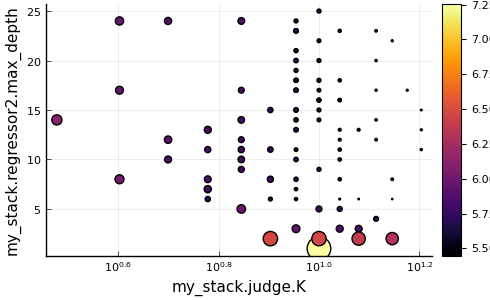

In [10]:
using Plots
pyplot()
plot(mach)

In [11]:
using Literate

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*